<a href="https://colab.research.google.com/github/FuadKhalit/Capstone_Project_APU-Algorithmic-Trading-Strategy-/blob/master/capstoneproject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install Library to be use in the experiment**

In [ ]:
#install Library
!pip install backtrader
!pip install pyfolio
!pip install bs4 --user
!pip install yfinance
!pip install pysentiment2

     |████████████████████████████████| 419kB 5.9MB/s 
     |████████████████████████████████| 92kB 4.3MB/s 
     |████████████████████████████████| 61kB 4.6MB/s 
  Created wheel for pyfolio: filename=pyfolio-0.9.2-cp36-none-any.whl size=88669 sha256=6ca0510025983a621e0fa7bb8cb26f4ac7a2707c52522b2b8c780fb73877400b
  Stored in directory: /root/.cache/pip/wheels/0d/a8/7d/ac33fe6bf6f3db370291c9de303460d00b8f97cc40a1d80f72
  Created wheel for empyrical: filename=empyrical-0.5.5-cp36-none-any.whl size=39765 sha256=780644d7db9fc4e16c186cd50db3a19c8142668462f1cd5680ce4aefb485ad95
  Stored in directory: /root/.cache/pip/wheels/ea/b2/c8/6769d8444d2f2e608fae2641833110668d0ffd1abeb2e9f3fc
Successfully built pyfolio empyrical
     |████████████████████████████████| 5.5MB 6.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=e1c5ad16ced4abdd2e0517cda0ede326b91ea76d5f0bcb247c85af6b28c016df
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4

# **Base Strategy - Buy and Hold Strategy**

---
This is our Benchmark model. Any model that performed better than our based model is considered very useful to be used in Algoritmic Trading 


In [ ]:
# Design the model strategy
import backtrader as bt


class BuyAndHold_Buy(bt.Strategy):
    def start(self):
        self.val_start = self.broker.get_cash()  # keep the starting cash

    def nextstart(self):
        # Buy stocks with all the available cash
        size = int(self.val_start / self.data)
        self.buy(size=size)

    def stop(self):
        # calculate the actual returns
        self.roi = (self.broker.get_value() / self.val_start) - 1.0
        print("ROI: %.2f, Cash: %.2f" % (100.0 * self.roi, self.broker.get_value()))

In [ ]:
# Execute the strategy in backtrader cerebro and monitor the log using pyfolio module
from datetime import datetime
import pyfolio as pf


data = bt.feeds.YahooFinanceData(
    dataname="TGLVY", fromdate=datetime(2018, 7, 12), todate=datetime(2020, 12, 31)
)


cerebro = bt.Cerebro()

cerebro.adddata(data)
cerebro.broker.setcash(100000.0)


cerebro.addstrategy(BuyAndHold_Buy, "HOLD")
# add analyzers
cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

# Execute
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
results = cerebro.run(stdstats=True, tradehistory=False)
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


Starting Portfolio Value: 100000.00
ROI: 43.19, Cash: 143185.78
Final Portfolio Value: 143185.78


In [ ]:
# Extract inputs for pyfolio
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
# Extract inputs for pyfolio
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2018-07-12 00:00:00+00:00    0.0
2018-07-13 00:00:00+00:00    0.0
Name: Strategy, dtype: float64

In [ ]:
# Showing the Model Performance
pf.show_perf_stats(returns,)

Start date,2018-07-12
End date,2020-12-30
Total months,29
,Backtest
Annual return,15.6%
Cumulative returns,43.2%
Annual volatility,103.1%
Sharpe ratio,0.68
Calmar ratio,0.20
Stability,0.35
Max drawdown,-77.3%


In [ ]:
#Preprocessing the output to be used in visualization
benchmark_rets= returns
benchmark_rets.index = benchmark_rets.index.tz_convert('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'BuyHold'
benchmark_rets.head(2)

index
2018-07-12 00:00:00+00:00    0.0
2018-07-13 00:00:00+00:00    0.0
Name: BuyHold, dtype: float64

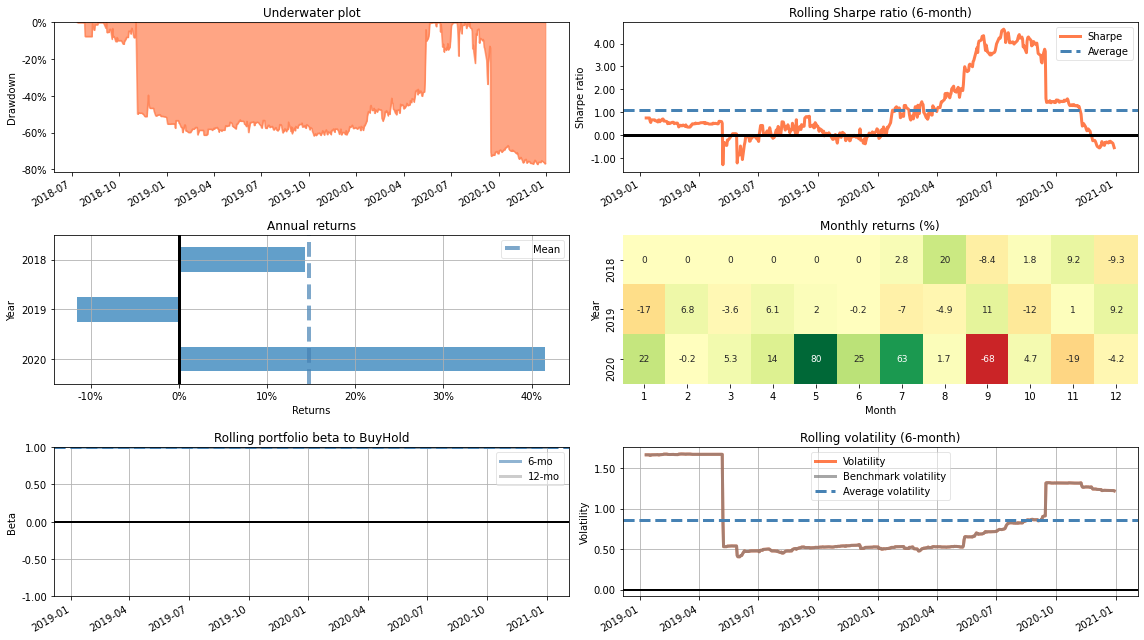

In [ ]:
#Visualization of the performance

%matplotlib inline
import matplotlib.pyplot as plt

# silence warnings
import warnings
warnings.filterwarnings('ignore')

# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[0])

axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[1])

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[4])
axes[4].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[5])
axes[5].grid(True)

plt.tight_layout()

In [ ]:
#Force reset to clear all input
%reset -f

# **Phase I - Sentiment Analysis**

---

This is our hybrid model based on Simple Moving Average and Sentiment Analysis. After the model was build, we evaluate the performance and validate it using backtesting. Then we analyze the result 

In [ ]:
import nltk
import warnings
warnings.filterwarnings('ignore')
import pysentiment2 as ps
import urllib
from urllib.request import urlopen
from urllib.error import HTTPError
from bs4 import BeautifulSoup
from datetime import datetime, timedelta
import time
import pprint

#Using Loughran and McDonald dictionary as main financial corpus
LNM = ps.LM() 


In [ ]:
#Extract news headline and score their sentiment using sentiment analyzer 
date_sentiments = {}
for i in range (1,11):
    page = urlopen('https://www.businesstimes.com.sg/search/top+glove?page='+str(i)).read()
    soup = BeautifulSoup(page, features="html.parser")
    posts = soup.findAll("div", {"class": "media-body"})# find the header
    for post in posts:
        time.sleep(2)
        url = post.a['href']
        date = post.time.text
        print(date, url)
        for setr in posts:
            passage=setr.find("p").text #save all the header in passage
        #use loughran mcdonald to calculate polarity of positive|negative news
        sentiment1=LNM.tokenize(passage)
        sentiment=LNM.get_score(sentiment1)['Polarity']
        date_sentiments.setdefault(date, []).append(sentiment)
date_sentiment = {}
for k,v in date_sentiments.items():
    date_sentiment[datetime.strptime(k, '%d %b %Y').date() + timedelta(days=1)] = round(sum(v)/float(len(v)),3)

earliest_date = min(date_sentiment.keys())

print(date_sentiments)

18 Jan 2021 https://www.businesstimes.com.sg/companies-markets/top-glove-screens-more-workers-after-some-test-positive
11 Jan 2021 https://www.businesstimes.com.sg/companies-markets/top-gloves-independent-directors-suffer-ire-of-institutional-investors
09 Jan 2021 https://www.businesstimes.com.sg/companies-markets/top-glove-defends-board-after-blackrock-criticism-0
08 Jan 2021 https://www.businesstimes.com.sg/companies-markets/top-glove-defends-board-after-blackrock-criticism
08 Jan 2021 https://www.businesstimes.com.sg/companies-markets/blackrock-raps-top-glove-board-over-worker-safety-0
07 Jan 2021 https://www.businesstimes.com.sg/companies-markets/blackrock-raps-top-glove-board-over-worker-safety
05 Jan 2021 https://www.businesstimes.com.sg/companies-markets/top-glove-commits-to-20-special-dividend-on-good-profit-performance-0
04 Jan 2021 https://www.businesstimes.com.sg/companies-markets/top-glove-commits-to-20-special-dividend-on-good-profit-performance
04 Jan 2021 https://www.bus

In [ ]:
#save the result in pickle so that we dont have to scrape the everytime we run the program

from google.colab import drive
from google.colab import drive
drive.mount('/content/drive')

# import pickle
# with open('/content/drive/MyDrive/save_webscrape', 'wb') as f:
#     pickle.dump(date_sentiment, f)
# with open('/content/drive/MyDrive/save_webscrape1', 'wb') as f:
#     pickle.dump(date_sentiments, f)
# with open('/content/drive/MyDrive/save_webscrape2', 'wb') as f:
    # pickle.dump(earliest_date, f)
# #load the pickle object
import pickle
with open('/content/drive/MyDrive/save_webscrape', 'rb') as f:
    date_sentiment = pickle.load(f)
with open('/content/drive/MyDrive/save_webscrape1', 'rb') as f:
    date_sentiments = pickle.load(f)
with open('/content/drive/MyDrive/save_webscrape2', 'rb') as f:
    earliest_date = pickle.load(f)

Mounted at /content/drive


In [ ]:
#To visualize the output of Sentiment Analysis
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.pyplot import figure
from matplotlib import rcParams


%matplotlib inline
df= pd.DataFrame.from_dict(date_sentiments,orient= 'index', columns=['compound','compound1', 'compound2','compound3','compound4'])
df.transpose()
#df = pd.DataFrame(df, columns=['Date', 'compound'])
df.index = pd.to_datetime(df.index)
df

#other compound are simply duplicate news within a day so we ignore it due to simplicity

,compound,compound1,compound2,compound3,compound4
2021-01-18,-1.000000,NaN,NaN,NaN,NaN
2021-01-11,-1.000000,NaN,NaN,NaN,NaN
2021-01-09,-1.000000,NaN,NaN,NaN,NaN
2021-01-08,-1.000000,-1.0,NaN,NaN,NaN
2021-01-07,-1.000000,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2018-10-11,-0.999999,NaN,NaN,NaN,NaN
2018-09-21,-0.999999,NaN,NaN,NaN,NaN
2018-07-30,-0.999999,NaN,NaN,NaN,NaN
2018-07-20,-0.999999,NaN,NaN,NaN,NaN


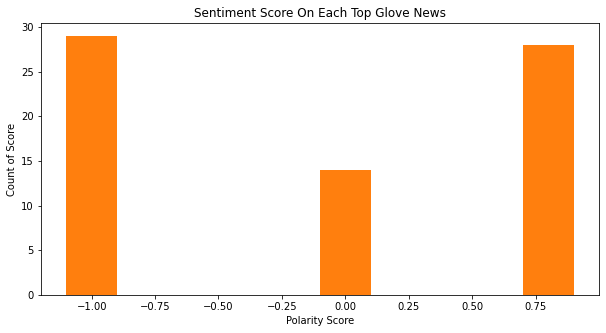

In [ ]:
#Plotting the polarity score
plt.figure(figsize=(10,5))
plt.hist(df['compound'],label=['Score','Count'], align='left', rwidth=0.9, color='tab:orange', histtype='stepfilled')
plt.title('Sentiment Score On Each Top Glove News')
plt.xlabel('Polarity Score')
plt.ylabel('Count of Score')
plt.show()

**Build Simple Moving Average Model**

---

Find the optimum Moving Average Period 

In [ ]:
#Run Hyperparameter Search to find best lagged for our Simple Moving Average

import yfinance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
import sklearn
from sklearn.metrics import mean_squared_error
import math
from datetime import datetime, timedelta

In [ ]:
plt.rcParams['figure.figsize'] = [10, 7]
plt.rc('font', size=14)
np.random.seed(0)


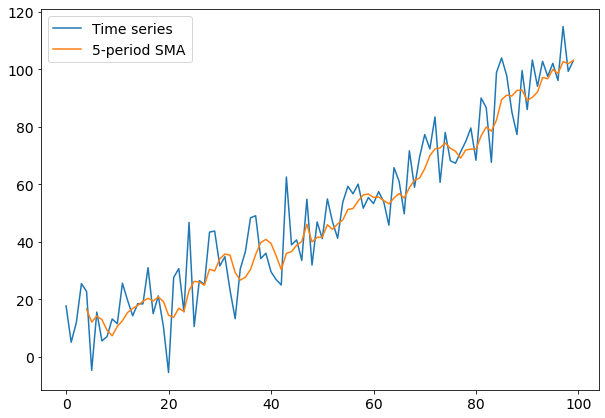

In [ ]:
y = np.arange(0,100,1) + np.random.normal(0,10,100)
sma = pd.Series(y).rolling(5).mean()
plt.plot(y,label="Time series")
plt.plot(sma,label="5-period SMA")

plt.legend()
plt.show()

In [ ]:
#Walk Forward Prediction
n_forward = 5 
name = 'TGLVY'
start_date = "2018-07-12"
end_date = "2020-12-31"

In [ ]:
#Declaring the variable
ticker = yfinance.Ticker('TGLVY')
data = ticker.history(interval="1d",start='2018-07-12',end=end_date)

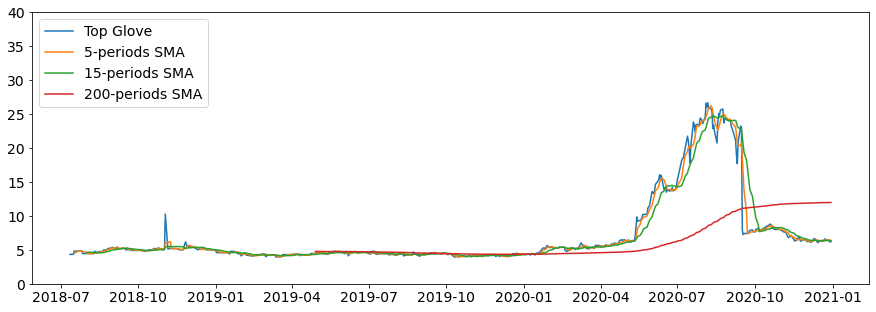

In [ ]:
#Visualize with common lagged period i.e. 5(Day Trader), 15(Swing Trader), 200 (Long Trader)
plt.figure(figsize=(15,5))
plt.plot(data['Close'],label="Top Glove")

plt.plot(data['Close'].rolling(5).mean(),label = "5-periods SMA")
plt.plot(data['Close'].rolling(15).mean(),label = "15-periods SMA")
plt.plot(data['Close'].rolling(200).mean(),label = "200-periods SMA")

plt.legend()
plt.ylim((0,40))
plt.show()


In [ ]:
#Extract historical market data from yfinance API  
ticker = yfinance.Ticker(name)
data = ticker.history(interval="1d",start=start_date,end=end_date)

data['Forward Close'] = data['Close'].shift(-n_forward)

data['Forward Return'] = (data['Forward Close'] - data['Close'])/data['Close']

In [ ]:
#Run the algorithm to find optimum moving average with maximum return
result = []
train_size = 0.75 #split dataset into Train(75) & Test(25)

for sma_length in range(5,500):
  
  data['SMA'] = data['Close'].rolling(sma_length).mean()
  data['input'] = [int(x) for x in data['Close'] > data['SMA']]
  
  df = data.dropna()

  training = df.head(int(train_size * df.shape[0]))
  test = df.tail(int((1 - train_size) * df.shape[0]))
  
  train_returns = training[training['input'] == 1]['Forward Return']
  test_returns = test[test['input'] == 1]['Forward Return']

  forward_return_training = train_returns.mean()
  forward_return_test = test_returns.mean()

  mse = sklearn.metrics.mean_squared_error(test['Close'], test['Forward Close'])
  rmse = math.sqrt(mse)

  result.append({
      'sma_length':sma_length,
      'forward_return_training': forward_return_training,
      'forward_return_test': forward_return_test,
      'RMSE' : rmse,
      'MSE' : mse
  })

/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 0 for slice
  **kwargs)
/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/local/lib/python3.6/dist-packages/numpy/core/fromnumeric.py:3622: RuntimeWarning: Degrees of freedom <= 

In [ ]:
# Sorted the best result from the algorithm
result.sort(key = lambda x : -x['test_forward_return'])
result[0]

#result
#n_forward(5) = [test_forward_return: 0.053, sma_length: 27, MSE: 9.3, RMSE: 3.05] 
#n_forward(10) = [test_forward_return: 0.112, sma_length: 25, MSE: 20.38, RMSE: 4.51  ]
#n_forward(15) = [test_forward_return: 0.173, sma_length: 25, MSE: 33.69, RMSE: 5.80 ]

{'MSE': 9.32420315652454,
 'RMSE': 3.0535558217469254,
 'sma_length': 27,
 'test_forward_return': 0.053287500961103705,
 'training_forward_return': 0.014118343632875455}

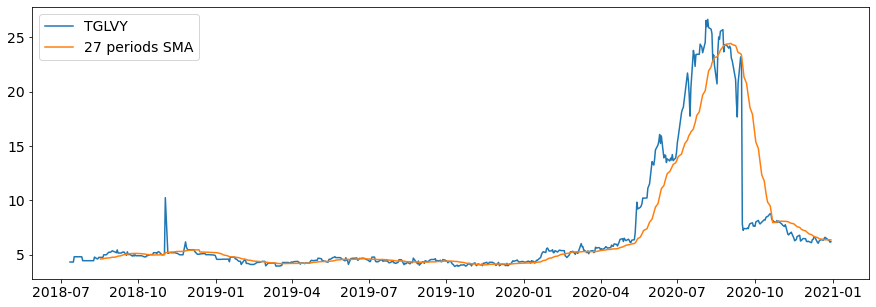

In [ ]:
#Plot the finding
best_sma = result[0]['sma_length']
data['SMA'] = data['Close'].rolling(best_sma).mean()

plt.figure(figsize=(15,5))
plt.plot(data['Close'],label=name)
plt.plot(data['SMA'],label = "{} periods SMA".format(best_sma))
plt.legend()
plt.show()

In [ ]:
#Visualize the SMA with Sentiment Analysis as Trade Signal
data['BEST_MA'] = data['Close'].rolling(25).mean()
data.dropna(inplace = True)

In [ ]:
#Combine Sentiment Analysis dataframe with SMA Dataframe
dfs= pd.DataFrame.from_dict(date_sentiments,orient= 'index', columns=['compound','compound1', 'compound2','compound3','compound4'])
datax=data.join(pd.DataFrame(dfs).rename(columns={'compound':'SIA','compound1':'SIA1','compound2':'SIA2','compound3':'SIA3','compound4':'SIA4'}))

In [ ]:
#MA Trade Calls
Trade_Buy = []
Trade_Sell = []

for i in range(len(datax) - 1):
    if ((datax['BEST_MA'].values[i] < datax['Close'].values[i]) & (datax['SIA'].values[i+1] > 0.5)):
        Trade_Buy.append(i)
    elif ((datax['BEST_MA'].values[i] > datax['Close'].values[i]) & (datax['SIA'].values[i+1] < 0)):
        Trade_Sell.append(i)

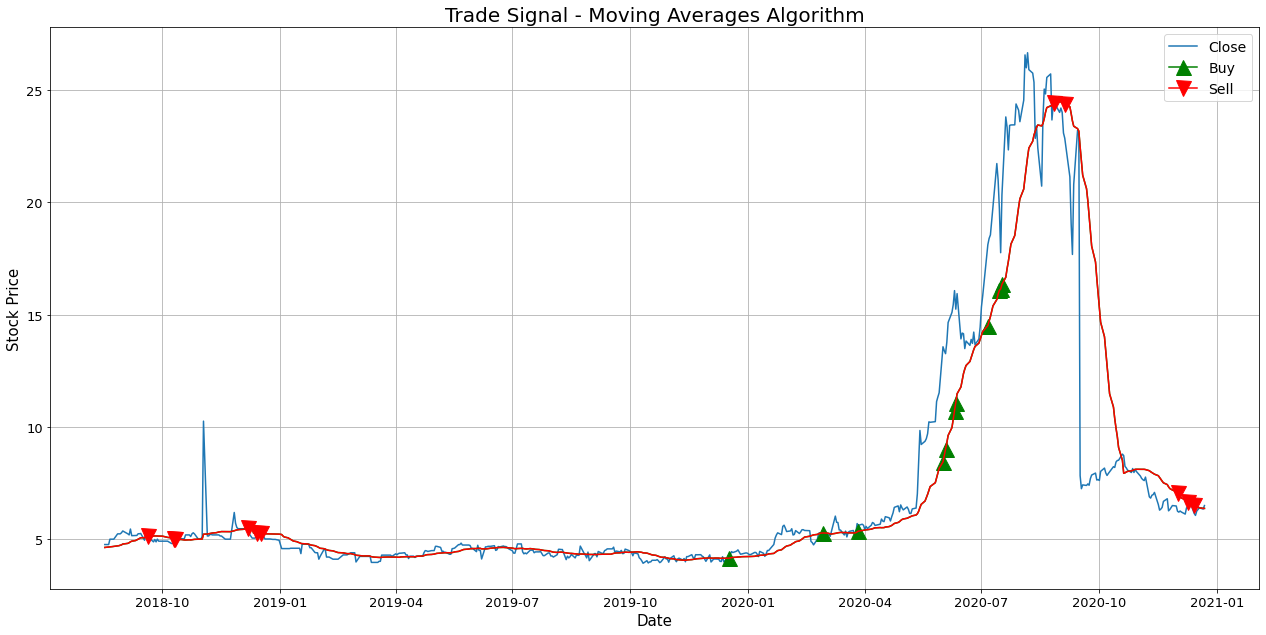

In [ ]:
from datetime import timedelta
fig, ax = plt.subplots(1, 1, figsize = (20, 10))

ax.plot(datax.index, datax['Close'])
ax.plot(datax.index, datax['BEST_MA'],'-^', markevery=Trade_Buy, ms=15, color = 'g')
ax.plot(data.index, datax['BEST_MA'],'-v', markevery=Trade_Sell, ms=15, color = 'r')
ax.set_xlabel('Date', fontsize = 15)
ax.set_ylabel('Stock Price', fontsize = 15)
ax.tick_params(axis = 'x', labelsize = 13)
ax.tick_params(axis = 'y', labelsize = 13)
ax.set_title('Trade Signal - Moving Averages Algorithm', fontdict = {'size': 20})
ax.legend(['Close','Buy','Sell'])
ax.grid()

plt.subplots_adjust(top = 0.92, left = 0.09, right = 0.93, bottom = 0.14, hspace = 0.3)
plt.show()

## **Run backtesting using SMA Optimize period**

In [ ]:
#Import the nessecery library
from __future__ import (absolute_import, division, print_function,unicode_literals)

import backtrader as bt
import backtrader.indicators as btind
import pyfolio as pf
import datetime
import os.path
import sys
import IPython

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [ ]:
class Sentiment(bt.Indicator):
    lines = ('sentiment',)
    plotinfo = dict(
        plotmargin = 0.15,
        plothlines = [0],
        plotyticks = [1.0, 0, -1.0]
    )
    
    def next(self):
        self.date = self.data.datetime
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
            self.lines.sentiment[0] = self.sentiment

In [ ]:
class SentimentStrat(bt.Strategy):
    params = (
        ('period', 27), #use optimized SMA Period
        ('printlog', True),
    )

    def log(self, txt, dt=None, doprint=False):
        ''' Logging function for this strategy'''
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s, %s' % (dt.isoformat(), txt))

    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # Keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None
        self.sma = bt.indicators.SimpleMovingAverage(
            self.datas[0], period=self.params.period)
        self.date = self.data.datetime
        self.sentiment = None
        Sentiment(self.data)
        
    def notify_order(self, order):
        # Buy/Sell order submitted/accepted to/by broker -> nothing to do
        if order.status in [order.Submitted, order.Accepted]:
            return 
        
        # Check if an order has been completed
        # Broker can reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(
                    'BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f'%
                    (order.executed.price,
                     order.executed.value,
                     order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
                
            else:
                self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        (order.executed.price,
                         order.executed.value,
                         order.executed.comm))
                self.bar_executed = len(self)
                
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')
        
        # No pending order
        self.order = None
            
    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f'%(trade.pnl, trade.pnlcomm))
        
    # Main strat    
    def next(self):
        # log close price of the series from the reference
        self.log('Close, %.2f' % self.dataclose[0])
        
        date = bt.num2date(self.date[0]).date()
        prev_sentiment = self.sentiment
        if date in date_sentiment:
            self.sentiment = date_sentiment[date]
        
        # check if an order is pending, if yes, we can't send a 2nd one
        if self.order:
            return
        print("Sentiment Score",self.sentiment)
        if not self.position and prev_sentiment:
        # buy maximum shares of the stock if the sentiment increases by 0.5 AND currenct close more than sma
            if self.dataclose[0] > prev_sentiment >= 0.5:#self.sma[0] and self.sentiment - 
                self.log('BUY CREATE, %.2f'% self.dataclose[0])
                self.order = self.buy()
                    
        elif prev_sentiment:
            # or sell if it decreases by 0.5 AND currenct close less than sma
            if self.dataclose[0] < self.sma[0] and self.sentiment - prev_sentiment <= -0.5:
                self.log('SELL CREATE, %.2f'% self.dataclose[0])
                self.order = self.sell()
                    
    def stop(self):
        self.log('(MA Period %2d) Ending Value %.2f' %
             (self.params.period, self.broker.getvalue()), doprint=True)


In [ ]:
if __name__ == '__main__':
    # https://www.backtrader.com/docu/strategy/
    cerebro = bt.Cerebro()
    
    # Strategy
    cerebro.addstrategy(SentimentStrat)

    # Data Feed
    data = bt.feeds.YahooFinanceData(
        dataname = 'TGLVY',
        fromdate = earliest_date,
        todate = datetime.datetime(2020,12,31),
        reverse = False
    )
    
    cerebro.adddata(data)
    # set the cash, stock size and commission
    cerebro.broker.setcash(100000.0)
    cerebro.addsizer(bt.sizers.FixedSize, stake=20000)
    cerebro.broker.setcommission(commission=0.001)

    # add analyzers
    cerebro.addanalyzer(bt.analyzers.Returns, _name='returns')
    cerebro.addanalyzer(bt.analyzers.TimeReturn, _name='time_return')
    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')



    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
    results = cerebro.run(stdstats=True, tradehistory=False)
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

Starting Portfolio Value: 100000.00
2018-08-17, Close, 4.76
Sentiment Score None
2018-08-20, Close, 4.76
Sentiment Score None
2018-08-21, Close, 5.00
Sentiment Score None
2018-08-22, Close, 5.00
Sentiment Score None
2018-08-23, Close, 5.00
Sentiment Score None
2018-08-24, Close, 5.00
Sentiment Score None
2018-08-27, Close, 5.23
Sentiment Score None
2018-08-28, Close, 5.23
Sentiment Score None
2018-08-29, Close, 5.23
Sentiment Score None
2018-08-30, Close, 5.28
Sentiment Score None
2018-08-31, Close, 5.36
Sentiment Score None
2018-09-04, Close, 5.23
Sentiment Score None
2018-09-05, Close, 5.19
Sentiment Score None
2018-09-06, Close, 5.45
Sentiment Score None
2018-09-07, Close, 5.15
Sentiment Score None
2018-09-10, Close, 5.16
Sentiment Score None
2018-09-11, Close, 5.16
Sentiment Score None
2018-09-12, Close, 5.24
Sentiment Score None
2018-09-13, Close, 5.24
Sentiment Score None
2018-09-14, Close, 5.25
Sentiment Score None
2018-09-17, Close, 4.95
Sentiment Score None
2018-09-18, Close, 

In [ ]:
#import library to analyze the result
import matplotlib
import matplotlib.pyplot as plt
import backtrader.analyzers as btanalyzers
import backtrader.feeds as btfeeds
from   backtrader.feeds import PandasData
import backtrader.strategies as btstrats
import backtrader.plot

In [ ]:
# Extract inputs for pyfolio
strat = results[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
# Extract inputs for pyfolio
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2018-07-12 00:00:00+00:00    0.0
2018-07-13 00:00:00+00:00    0.0
Name: Strategy, dtype: float64

In [ ]:
# get performance statistics for strategy
pf.show_perf_stats(returns,)

Start date,2018-07-12
End date,2020-12-30
Total months,29
,Backtest
Annual return,26.2%
Cumulative returns,77.9%
Annual volatility,59.6%
Sharpe ratio,0.80
Calmar ratio,0.37
Stability,0.48
Max drawdown,-71.2%


In [ ]:
# get benchmark returns
benchmark_rets= returns
benchmark_rets.index = benchmark_rets.index.tz_convert('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'SMA'
benchmark_rets.head(2)

index
2018-07-12 00:00:00+00:00    0.0
2018-07-13 00:00:00+00:00    0.0
Name: SMA, dtype: float64

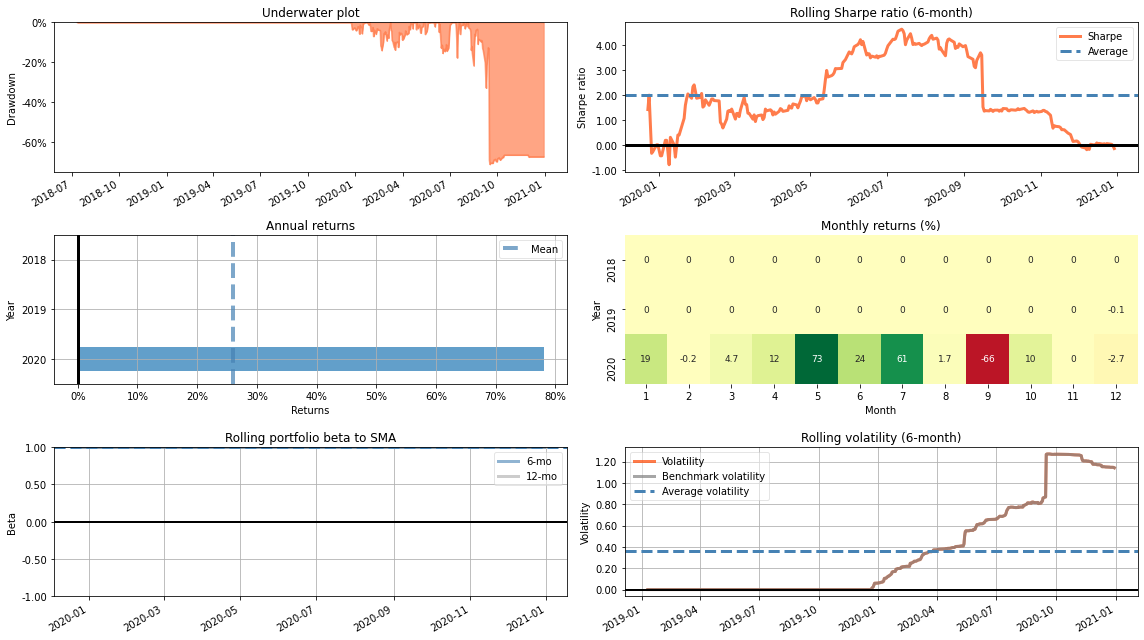

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# silence warnings
import warnings
warnings.filterwarnings('ignore')

# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[0])

axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[1])

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[4])
axes[4].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[5])
axes[5].grid(True)

plt.tight_layout()

In [ ]:
#Force reset to clear all input
%reset -f

# **Phase II - Machine Learning Model**

---

We build 5 machine learning model


*   Logistic Regression
*   Gaussian Naive Bayes
*   SVM
*   Random Forest
*   Multi-Layer Perceptron <br>
Then we evaluate the performance and finally run backtesting to validate the result.







In [ ]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns
import yfinance as yf
import warnings
import sklearn
from sklearn import linear_model
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import mean_squared_error
import math
import datetime
import pyfolio as pf
import backtrader as bt
from backtrader.feeds import PandasData



# set the style and ignore warnings
plt.style.use('seaborn-colorblind')
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings('ignore')

/usr/local/lib/python3.6/dist-packages/pyfolio/pos.py:28: UserWarning: Module "zipline.assets" not found; mutltipliers will not be applied to position notionals.
  ' to position notionals.'


In [ ]:
# ticker and the start and end dates for testing
ticker =  'TGLVY' # Top Glove ticker = TGLVY | Axiata = AXXTF | Maybank = MLYNF 
start = datetime.datetime(2018, 7, 12) #start date to extract
end = datetime.datetime(2020, 12, 31) #end date to extract

In [ ]:
# Extract data from yahoo finance API 
stock =  yf.download(ticker, progress=True, actions=True,start=start, end=end)['Adj Close']
stock = pd.DataFrame(stock)#load into pandas dataframe 
stock.rename(columns = {'Adj Close':ticker}, inplace=True)
stock.head(5)

[*********************100%***********************]  1 of 1 completed


,TGLVY
Date,
2018-07-12,4.329658
2018-07-13,4.329658
2018-07-16,4.329658
2018-07-17,4.817339
2018-07-18,4.817339


In [ ]:
# calculate daily log returns and market direction
stock['returns'] = np.log(stock / stock.shift(1))
stock.dropna(inplace=True)
stock['direction'] = np.sign(stock['returns']).astype(int)
stock.head(5)

,TGLVY,returns,direction
Date,,,
2018-07-13,4.329658,0.000000,0
2018-07-16,4.329658,0.000000,0
2018-07-17,4.817339,0.106733,1
2018-07-18,4.817339,0.000000,0
2018-07-19,4.817339,0.000000,0


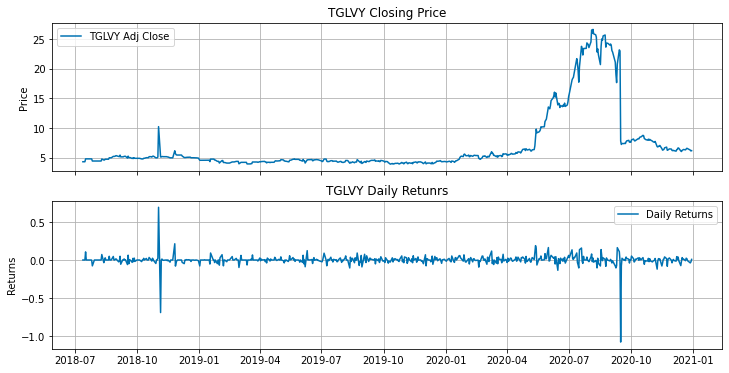

In [ ]:
# visualize the closing price and daily returns
fig, ax = plt.subplots(2, 1, sharex=True, figsize = (12,6))
ax[0].plot(stock[ticker], label = f'{ticker} Adj Close')
ax[0].set(title = f'{ticker} Closing Price', ylabel = 'Price')
ax[0].grid(True)
ax[0].legend()

ax[1].plot(stock['returns'], label = 'Daily Returns')
ax[1].set(title = f'{ticker} Daily Retunrs', ylabel = 'Returns')
ax[1].grid(True)
plt.legend()



In [ ]:
# define the number of lags
lags = [1, 2, 3, 4, 5]

In [ ]:
# compute lagged log returns
cols = []
for lag in lags:
    col = f'rtn_lag{lag}'
    stock[col] = stock['returns'].shift(lag)
    cols.append(col)

stock.dropna(inplace=True)
stock.head(3)

,TGLVY,returns,direction,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5
Date,,,,,,,,
2018-07-20,4.817339,0.0,0,0.0,0.0,0.106733,0.000000,0.000000
2018-07-23,4.817339,0.0,0,0.0,0.0,0.000000,0.106733,0.000000
2018-07-24,4.817339,0.0,0,0.0,0.0,0.000000,0.000000,0.106733


In [ ]:
# function to transform the lag returns to binary values (0,+1)
def create_bins(data, bins=[0]):
    global cols_bin
    cols_bin = []
    for col in cols:
        col_bin = col + '_bin'
        data[col_bin] = np.digitize(data[col], bins=bins)  
        cols_bin.append(col_bin)

In [ ]:
# normalize the data in order for the model to use it as input
create_bins(stock)
stock[cols+cols_bin].head(10)

,rtn_lag1,rtn_lag2,rtn_lag3,rtn_lag4,rtn_lag5,rtn_lag1_bin,rtn_lag2_bin,rtn_lag3_bin,rtn_lag4_bin,rtn_lag5_bin
Date,,,,,,,,,,
2018-07-20,0.000000,0.000000,0.106733,0.000000,0.000000,1,1,1,1,1
2018-07-23,0.000000,0.000000,0.000000,0.106733,0.000000,1,1,1,1,1
2018-07-24,0.000000,0.000000,0.000000,0.000000,0.106733,1,1,1,1,1
2018-07-25,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1
2018-07-26,0.000000,0.000000,0.000000,0.000000,0.000000,1,1,1,1,1
2018-07-27,-0.001492,0.000000,0.000000,0.000000,0.000000,0,1,1,1,1
2018-07-30,-0.077070,-0.001492,0.000000,0.000000,0.000000,0,0,1,1,1
2018-07-31,0.000000,-0.077070,-0.001492,0.000000,0.000000,1,0,0,1,1
2018-08-01,0.000000,0.000000,-0.077070,-0.001492,0.000000,1,1,0,0,1


**Building the Top 3 Model**

In [ ]:
# create a dictionary of selected algorithms & conduct manual hyperparameter optimizer
models = {
    'log_reg': linear_model.LogisticRegression(),
    'gauss_nb': GaussianNB(),
    'svm': SVC(),
    'random_forest': RandomForestClassifier(n_estimators=200, max_depth=10),
    'MLP' : MLPClassifier(max_iter=500,hidden_layer_sizes=(128,),activation='relu',solver='adam',learning_rate_init=0.01, alpha=0.001),
}

In [ ]:
# function that fits all models.
def fit_models(data):  
    mfit = {model: models[model].fit(data[cols_bin], data['direction']) for model in models.keys()}

In [ ]:
# function that predicts (derives all position values) from the fitted models
def derive_positions(data):  
    for model in models.keys():
        data['pos_' + model] = models[model].predict(data[cols_bin])

In [ ]:
# function to evaluate all trading strategies
def evaluate_strats(data):  
    global strategy_rtn
    strategy_rtn = []
    for model in models.keys():
        col = 'strategy_' + model 
        data[col] = data['pos_' + model] * data['returns']
        strategy_rtn.append(col)
    strategy_rtn.insert(0, 'returns')

In [ ]:
# fit the models
fit_models(stock)

# derives all position values
derive_positions(stock)

# evaluate all trading strategies by multiplying predicted directions to actual daily returns
evaluate_strats(stock)

In [ ]:
# calculate total return and std. deviation of each strategy
print('\nTotal Returns:')
print(stock[strategy_rtn].sum().apply(np.exp))
print('\nAnnual Volatility:')
stock[strategy_rtn].std() * 252 ** 0.5


Total Returns:
returns                   1.287017
strategy_log_reg          1.744055
strategy_gauss_nb         0.911785
strategy_svm              3.533975
strategy_random_forest    5.389144
strategy_MLP              5.943187
dtype: float64

Annual Volatility:


returns                   1.110451
strategy_log_reg          1.094012
strategy_gauss_nb         0.964071
strategy_svm              1.093622
strategy_random_forest    1.093245
strategy_MLP              1.093143
dtype: float64

In [ ]:
# Calculate the accuracy of each model
from sklearn.metrics import accuracy_score
Accuracy = [accuracy_score(stock['direction'], stock['pos_log_reg']), accuracy_score(stock['direction'], stock['pos_gauss_nb']),accuracy_score(stock['direction'], stock['pos_svm']), accuracy_score(stock['direction'], stock['pos_random_forest']),accuracy_score(stock['direction'], stock['pos_MLP'])]

#store in dataframe
pd.DataFrame([Accuracy],index=['Accuracy Score'],columns=['Logistic Regression','Gaussian Naive Bayes', 'Support Vector Machine','Random Forest','Multi-Layer Perceptron '])

,Logistic Regression,Gaussian Naive Bayes,Support Vector Machine,Random Forest,Multi-Layer Perceptron
Accuracy Score,0.442464,0.424635,0.479741,0.482982,0.471637


In [ ]:
#print the classification report
from sklearn.metrics import classification_report

print("Logistic Regression:\n",classification_report(stock['direction'], stock['pos_log_reg']))
print("Gaussian Naive Bayes:\n",classification_report(stock['direction'], stock['pos_gauss_nb']))
print("Support Vector Machine:\n",classification_report(stock['direction'], stock['pos_svm']))
print("Random Forest :\n",classification_report(stock['direction'], stock['pos_random_forest']))
print("Multilayer Perceptron:\n",classification_report(stock['direction'], stock['pos_MLP']))

Logistic Regression:
               precision    recall  f1-score   support

          -1       0.40      0.39      0.39       230
           0       0.49      0.28      0.35       141
           1       0.46      0.59      0.52       246

    accuracy                           0.44       617
   macro avg       0.45      0.42      0.42       617
weighted avg       0.44      0.44      0.43       617

Gaussian Naive Bayes:
               precision    recall  f1-score   support

          -1       0.40      0.23      0.29       230
           0       0.38      0.47      0.42       141
           1       0.46      0.59      0.52       246

    accuracy                           0.42       617
   macro avg       0.41      0.43      0.41       617
weighted avg       0.42      0.42      0.41       617

Support Vector Machine:
               precision    recall  f1-score   support

          -1       0.50      0.38      0.43       230
           0       0.49      0.28      0.35       141
     

In [ ]:
# number of trades over time top 3 highest return strategy
print('Number of trades SVM = ', (stock['pos_svm'].diff()!=0).sum())
print('Number of trades Multilayer Perceptron = ',(stock['pos_MLP'].diff()!=0).sum())
print('Number of trades Random Forest = ',(stock['pos_random_forest'].diff()!=0).sum())


Number of trades SVM =  226
Number of trades Multilayer Perceptron =  275
Number of trades Random Forest =  238


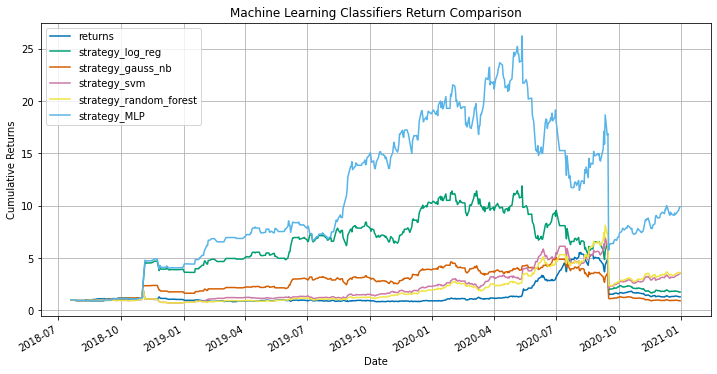

In [ ]:
# vectorized backtesting of the resulting trading strategies and visualize the performance over time
ax = stock[strategy_rtn].cumsum().apply(np.exp).plot(figsize=(12, 6), 
                                                     title = 'Machine Learning Classifiers Return Comparison')
ax.set_ylabel("Cumulative Returns")
ax.grid(True);
# plt.tight_layout();
# plt.savefig('images/chart2', dpi=300)

## **Run Backtesting**

In [ ]:
# fetch the daily pricing data from yahoo finance
prices =  yf.download(ticker, progress=True, actions=True, start=start, end=end)
prices.head(2)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,Dividends,Stock Splits
Date,,,,,,,,
2018-07-12,4.55,4.55,4.55,4.55,4.329658,0,0.0,0.0
2018-07-13,4.55,4.55,4.55,4.55,4.329658,0,0.0,0.0


In [ ]:
# rename the columns as needed for Backtrader
prices.drop(['Close','Dividends','Stock Splits'], inplace=True, axis=1)
prices.rename(columns = {'Open':'open','High':'high','Low':'low','Adj Close':'close','Volume':'volume',
                         }, inplace=True)
prices.head(3)

,open,high,low,close,volume
Date,,,,,
2018-07-12,4.55,4.55,4.55,4.329658,0
2018-07-13,4.55,4.55,4.55,4.329658,0
2018-07-16,4.55,4.55,4.55,4.329658,0


In [ ]:
# add the predicted column to prices dataframe. This will be used as signal for buy or sell
predictions = stock['strategy_MLP'] # top 3 = strategy_random_forest | strategy_svm | strategy_MLP
predictions = pd.DataFrame(predictions)
predictions.rename(columns = {'strategy_MLP':'predicted'}, inplace=True)# top 3 = strategy_random_forest | strategy_svm | strategy_MLP
prices = predictions.join(prices, how='right').dropna()
prices.head(5)

,predicted,open,high,low,close,volume
Date,,,,,,
2018-07-20,0.0,5.06250,5.06250,5.06250,4.817339,0
2018-07-23,0.0,5.06250,5.06250,5.06250,4.817339,0
2018-07-24,0.0,5.06250,5.06250,5.06250,4.817339,0
2018-07-25,0.0,5.06250,5.06250,5.06250,4.817339,0
2018-07-26,-0.0,5.05495,5.05495,5.05495,4.810155,200


In [ ]:
OHLCV = ['open', 'high', 'low', 'close', 'volume']

In [ ]:
# class to define the columns we will provide
class SignalData(PandasData):
    """
    Define pandas DataFrame structure
    """
    cols = OHLCV + ['predicted']

    # create lines
    lines = tuple(cols)

    # define parameters
    params = {c: -1 for c in cols}
    params.update({'datetime': None})
    params = tuple(params.items())

In [ ]:
# define backtesting strategy class
class MLStrategy(bt.Strategy):
    params = dict(
    )
    
    def __init__(self):
        # keep track of open, close prices and predicted value in the series
        self.data_predicted = self.datas[0].predicted
        self.data_open = self.datas[0].open
        self.data_close = self.datas[0].close
        
        # keep track of pending orders/buy price/buy commission
        self.order = None
        self.price = None
        self.comm = None

    # logging function
    def log(self, txt):
        '''Logging function'''
        dt = self.datas[0].datetime.date(0).isoformat()
        print(f'{dt}, {txt}')

    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # order already submitted/accepted - no action required
            return

        # report executed order
        if order.status in [order.Completed]:
            if order.isbuy():
                self.log(f'BUY EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )
                self.price = order.executed.price
                self.comm = order.executed.comm
            else:
                self.log(f'SELL EXECUTED --- Price: {order.executed.price:.2f}, Cost: {order.executed.value:.2f},Commission: {order.executed.comm:.2f}'
                )

        # report failed order
        elif order.status in [order.Canceled, order.Margin, 
                              order.Rejected]:
            self.log('Order Failed')

        # set no pending order
        self.order = None

    def notify_trade(self, trade):
        if not trade.isclosed:
            return
        self.log(f'OPERATION RESULT --- Gross: {trade.pnl:.2f}, Net: {trade.pnlcomm:.2f}')

    # We have set cheat_on_open = True.This means that we calculated the signals on day t's close price, 
    # but calculated the number of shares we wanted to buy based on day t+1's open price.
    def next_open(self):
        if not self.position:
            if self.data_predicted > 0:
                # calculate the max number of shares ('all-in')
                size = int(self.broker.getcash() / self.datas[0].open)
                # buy order
                self.log(f'BUY CREATED --- Size: {size}, Cash: {self.broker.getcash():.2f}, Open: {self.data_open[0]}, Close: {self.data_close[0]}')
                self.buy(size=size*0.99)
        else:
            if self.data_predicted < 0:
                # sell order
                self.log(f'SELL CREATED --- Size: {self.position.size}')
                self.sell(size=self.position.size)

In [ ]:
# instantiate SignalData class
data = SignalData(dataname=prices)

In [ ]:
# instantiate Cerebro, add strategy, data, initial cash, commission and pyfolio for performance analysis
cerebro = bt.Cerebro(stdstats = False, cheat_on_open=True)
cerebro.addstrategy(MLStrategy)
cerebro.adddata(data, name=ticker)
cerebro.broker.setcash(100000.0)
cerebro.broker.setcommission(commission=0.001)
cerebro.addanalyzer(bt.analyzers.PyFolio, _name='pyfolio')

In [ ]:
# run the backtest
print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())
backtest_result = cerebro.run()
print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

#RF Final Portfolio Value: 337380.55
#SVM Final Portfolio Value: 231954.50
#MLP Final Portfolio Value: 113014.31

Starting Portfolio Value: 100000.00
2018-08-15, BUY CREATED --- Size: 20000, Cash: 100000.00, Open: 5.0, Close: 4.757866382598877
2018-08-15, BUY EXECUTED --- Price: 5.00, Cost: 99000.00,Commission: 99.00
2018-09-05, SELL CREATED --- Size: 19800.0
2018-09-05, SELL EXECUTED --- Price: 5.49, Cost: 99000.00,Commission: 108.65
2018-09-05, OPERATION RESULT --- Gross: 9652.50, Net: 9444.85
2018-09-06, BUY CREATED --- Size: 19117, Cash: 109444.85, Open: 5.724999904632568, Close: 5.447756767272949
2018-09-06, BUY EXECUTED --- Price: 5.72, Cost: 108350.37,Commission: 108.35
2018-09-12, SELL CREATED --- Size: 18925.829999999998
2018-09-12, SELL EXECUTED --- Price: 5.51, Cost: 108350.37,Commission: 104.19
2018-09-12, OPERATION RESULT --- Gross: -4163.68, Net: -4376.22
2018-09-18, BUY CREATED --- Size: 19103, Cash: 105068.64, Open: 5.5, Close: 5.27171516418457
2018-09-18, BUY EXECUTED --- Price: 5.50, Cost: 104015.84,Commission: 104.02
2018-09-19, SELL CREATED --- Size: 18911.97
2018-09-19, SELL E

In [ ]:
# Extract inputs for pyfolio
strat = backtest_result[0]
pyfoliozer = strat.analyzers.getbyname('pyfolio')
returns, positions, transactions, gross_lev = pyfoliozer.get_pf_items()
returns.name = 'Strategy'
returns.head(2)

index
2018-07-20 00:00:00+00:00    0.0
2018-07-23 00:00:00+00:00    0.0
Name: Strategy, dtype: float64

In [ ]:
# get benchmark returns
benchmark_rets= stock['returns']
benchmark_rets.index = benchmark_rets.index.tz_localize('UTC') 
benchmark_rets = benchmark_rets.filter(returns.index)
benchmark_rets.name = 'ML Model'
benchmark_rets.head(2)

Date
2018-07-20 00:00:00+00:00    0.0
2018-07-23 00:00:00+00:00    0.0
Name: ML Model, dtype: float64

In [ ]:
# get performance statistics for strategy
pf.show_perf_stats(returns)

Start date,2018-07-20
End date,2020-12-30
Total months,29
,Backtest
Annual return,42.6%
Cumulative returns,138.3%
Annual volatility,90.0%
Sharpe ratio,0.79
Calmar ratio,0.68
Stability,0.51
Max drawdown,-62.3%


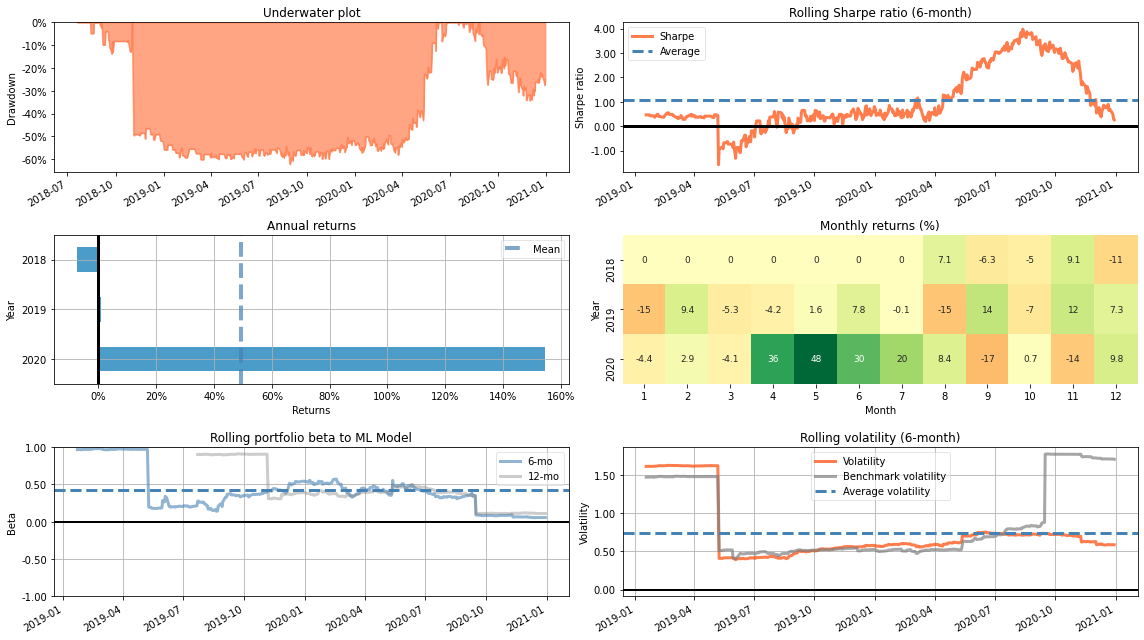

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

# silence warnings
import warnings
warnings.filterwarnings('ignore')

# plot performance for strategy vs benchmark
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(16, 9),constrained_layout=True)
axes = ax.flatten()

axes[1].grid(True)
pf.plot_drawdown_underwater(returns=returns, ax=axes[0])

axes[2].grid(True)
pf.plot_rolling_sharpe(returns=returns, ax=axes[1])

pf.plot_annual_returns(returns=returns, ax=axes[2])
axes[2].grid(True)

pf.plot_monthly_returns_heatmap(returns=returns, ax=axes[3],)

pf.plot_rolling_beta(returns=returns, factor_returns=benchmark_rets, ax=axes[4])
axes[4].grid(True)

pf.plot_rolling_volatility(returns=returns, factor_returns=benchmark_rets,ax=axes[5])
axes[5].grid(True)

plt.tight_layout()